<a href="https://colab.research.google.com/github/henrykohl/DeepLearningByPytorchTutorial/blob/master/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="red">06. PyTorch Transfer Learning Exercises</font>

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3768, done.
remote: Counting objects: 100% (390/390), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 3768 (delta 209), reused 322 (delta 169), pack-reused 3378
Receiving objects: 100% (3768/3768), 648.93 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (2165/2165), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data ( 1-1 )

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")                
"""設定 "data" 目錄路徑，物件類型為Path"""
image_path = data_path / "pizza_steak_sushi"     
"""設定 "data/pizza_steak_sushi" 資料夾路徑，物件類型為Path"""

# If the image folder doesn't exist, download it and prepare it... (檢查是否為目錄) 
if image_path.is_dir():                   
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)  
  """建立"data/pizza_steak_sushi"目錄"""
  
  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:                                
    """開啟 pizza_steak_sushi.zip"""
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") 
    """下載 pizza_steak_sushi.zip"""
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)                                                 
    """寫入 pizza_steak_sushi.zip"""

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:                    
    """存取zip檔""" 

    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)                                          
    """將zip檔解壓縮到"data/pizza_steak_sushi"資料夾"""

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")                                     
  """移除zip檔"""

# Setup Dirs
train_dir = image_path / "train"                                                
"""設置訓練目錄"""
test_dir = image_path / "test"                                                 
"""設置測試目錄"""

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


'設置測試目錄'

### Prepare data

In [4]:
# Create a transforms pipeline 
"""
建立 transforms
"""
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
               std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
"""
建立 訓練dataloader,測試dataloader, 類名稱集: batch size大小為32
"""
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                            test_dir=test_dir,
                                            transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                            batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names 

(<torch.utils.data.dataloader.DataLoader at 0x7f7293603ac0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device 
"""
過時的舊方式
"""
# model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device) 
#model_0 # 測試 uncomment to output (it's very long)

"""
新方式 of creating a pretrained model (torchvision v0.13+)
"""
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device) 

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 66.7MB/s]


In [7]:
# Print with torchinfo
from torchinfo import summary

summary(model=model_0,
    input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
"""
原始解答寫法
"""
# for param in model_0.features.parameters():
#     param.requires_grad = False
"""
另一寫法
"""
for param in model_0.parameters():
    param.requires_grad = False

In [9]:
"""
Freezing之後，用summary檢視model_0，可以看到Trainable那一欄都變成了False
"""
summary(model=model_0,
    input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [10]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
            out_features=output_shape, # same number of output units as our number of classes
            bias=True)).to(device)

### Train model

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001) # 沒標params也可以

In [12]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=5,
                  device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0894 | train_acc: 0.4492 | test_loss: 0.9214 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8697 | train_acc: 0.7734 | test_loss: 0.8036 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7769 | train_acc: 0.7734 | test_loss: 0.7404 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7244 | train_acc: 0.7422 | test_loss: 0.6488 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6426 | train_acc: 0.7812 | test_loss: 0.6254 | test_acc: 0.8968
[INFO] Total training time: 24.431 seconds


### Make predictions on the entire test dataset with the model

In [13]:
# TODO

In [14]:
# len(test_dataloader)

**<font color="red">測試筆記</font>**

```
X, y = next(iter(test_dataloader))
X.shape, y.shape
```
(torch.Size([32, 3, 224, 224]), torch.Size([32]))
```
model_0.eval()
with torch.inference_mode():
  X, y = X.to(device), y.to(device)
  test_logits = model_0(X)

test_logits.shape  
```
torch.Size([32, 3])
```
pred_probs = torch.softmax(test_logits, dim=1)
pred_probs.shape
```
torch.Size([32, 3])
```
pred_labels = torch.argmax(pred_probs, dim=1)
pred_labels, pred_labels.shape
```
(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 2, 1, 1]),
 torch.Size([32]))

---




In [15]:
from tqdm.auto import tqdm

# (Make predictions on the entire test dataset)
test_preds = []
model_0.eval()
with torch.inference_mode():
  # (Loop through the batches in the test dataloader)
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    """
    X 大小為 torch.Size([32, 3, 224, 224]), y 大小為 torch.Size([32]))
    """
    # (Pass the data through the model)
    test_logits = model_0(X)
    """
    test_logits 大小為 torch.Size([32, 3])
    """

    # (Convert the pred logits to pred probs)
    pred_probs = torch.softmax(test_logits, dim=1)
    """
    pred_probs 大小為 torch.Size([32, 3])
    """

    # (Convert the pred probs into pred labels)
    pred_labels = torch.argmax(pred_probs, dim=1)
    """
    pred_labels 大小為 torch.Size([32])
    """
                               
    # (Add the pred labels to test preds list)
    test_preds.append(pred_labels)

"""
此時test_preds的長度為3, 也就是包含了3個tensor，可以測試：
test_preds[0].shape, test_preds[1].shape, test_preds[2].shape, 
結果：
(torch.Size([32]), torch.Size([32]), torch.Size([11]))

"""
# (Concatenate the test preds and put them on the CPU)
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])



```
test_preds[0].shape, test_preds[1].shape, test_preds[2].shape,
```
(torch.Size([32]), torch.Size([32]), torch.Size([11]))


### Make a confusion matrix with the test preds and the truth labels

In [16]:
# (Get the truth labels for test dataset)
test_truth = torch.cat([y for _, y in test_dataloader])
# test_truth = test_truth.to(device)
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [17]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.1 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [18]:
# Import mlxtend upgraded version
# import mlxtend 
# print(mlxtend.__version__)
# assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

In [19]:
# import mlxtend 
print(mlxtend.__version__)

0.22.0


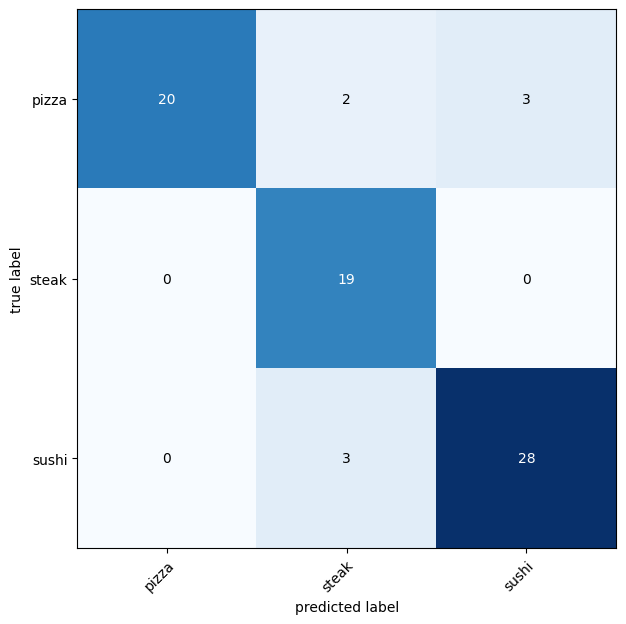

In [20]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# (Setup confusion matrix instance)
confmat = ConfusionMatrix(task="multiclass",num_classes=len(class_names))
# confmat = confmat.to(device)          # 如果preds與target都在GPU上，confmat也要移到GPU
confmat_tensor =confmat(preds= test_preds,
             target= test_truth)    # 若confmat_tensor在GPU，就要移到CPU，因為numpy()只能在CPU運作

# (Plot the confusion matrix)
fig, ax = plot_confusion_matrix(
    conf_mat= confmat_tensor.cpu().numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10,7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [21]:
# TODO


```
test_data_paths[0]
```
PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg')


In [22]:
# (Get all test data paths)
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
"""
或是 list(test_dir.glob("*/*.jpg"))，因為test_dir本身就是就是pathlib.Path物件
"""
test_labels = [path.parent.stem for path in test_data_paths]


# (Create a function to return a list of dictionaries with sample, label, prediction, pred prob)
def pred_and_store(test_data_paths, model, transform, class_names, device):
  test_pred_list = []
  """test_pred_list為list, 之後會寫入一個個dict"""

  for path in tqdm(test_data_paths):
    # (Create empty dict to store info for each sample)
    pred_dict = {}
    """pred_dict為dict"""

    # (Get sample path)
    pred_dict["image_page"] = path
    """image_page:路徑"""

    # (Get class name)
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name
    """class_name:類名稱"""

    # (Get prediction and prediction probability)
    from PIL import Image
    img = Image.open(path) # (open image)
    transformed_image = transform(img).unsqueeze(0)    # (transform image and add batch dimension)
    """transformed_image是一個tensor"""

    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      """pred_logit 大小為 torch.Size([1, 3])"""

      pred_prob = torch.softmax(pred_logit,dim=1)
      """pred_prob 大小為 torch.Size([1, 3])"""

      pred_label = torch.argmax(pred_prob,dim=1)
      """pred_prob 大小為 torch.Size([1])"""

      pred_class = class_names[pred_label.cpu()]
      """pred_class是str類型"""  
      """寫成class_names[pred_label]或class_names[pred_label.item()]都可以"""
      
      # (Make sure things in the dictionary are back on the CPU) 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item() 
      """
      pred_prob.unsqueeze(0).shape    是 torch.Size([1, 1, 3])
      似乎不需要unsqueeze(0)，也不需要cpu()。item()是用來把torch轉換成值本身的類型，這裡是probability所以是float
      pred_prob.unsqueeze(0).max().shape 是 torch.Size([])
      pred_prob.max().shape       也是 torch.Size([])
      """    

    # (Does the pred match the true label?)
    pred_dict["correct"] = class_name == pred_class 
    """correct:Boolean值"""

    #  print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list # 無return的話，會出錯TypeError: 'NoneType' object is not subscriptable

test_pred_dicts = pred_and_store(test_data_paths=test_data_paths, 
                   model=model_0, 
                   transform=simple_transform, 
                   class_names=class_names, 
                   device=device)
test_pred_dicts

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_page': PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4524088203907013,
  'correct': True},
 {'image_page': PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4694538116455078,
  'correct': True},
 {'image_page': PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.772383451461792,
  'correct': True},
 {'image_page': PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7118026614189148,
  'correct': True},
 {'image_page': PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7658573389053345,
  'correct': True}]

In [23]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd 
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct","pred_prob"],ascending=[True,False]).head()
"""
by=["correct"]意味排序根據correct欄位boolean值，對應ascending=[True]，所以correct=False會列在前面，correct=True，列在後面
by=["pred_prob"]意味排序根據pred_prob欄位機率值，對應ascending=[False]，所以機率高的會列在前面，機率低的會列在後面
"""
# top_5_most_wrong = test_pred_df[test_pred_df["correct"]==False].sort_values(by=["pred_prob"],ascending=[False]).head() # 與上式相等
top_5_most_wrong

,image_page,class_name,pred_prob,correct
46,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.547931,False
23,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.454041,False
44,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.448240,False
8,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.428751,False
19,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,0.424841,False


<font color="red">範例測試</font>

```
arow = next(top_5_most_wrong.iterrows())
```
(30,
 image_page    data/pizza_steak_sushi/test/sushi/684266.jpg
 class_name    sushi
 pred_prob     0.509456
 correct      False
 Name: 30, dtype: object)



```
len(arow)
```
2



```
arow[0]
```
30








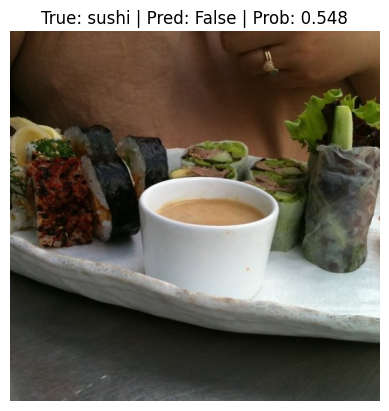

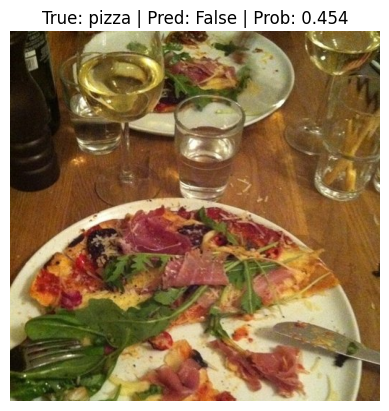

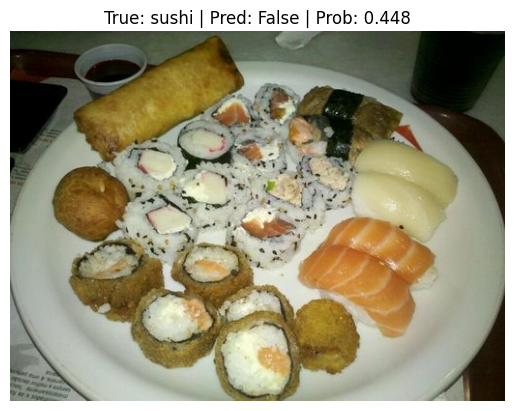

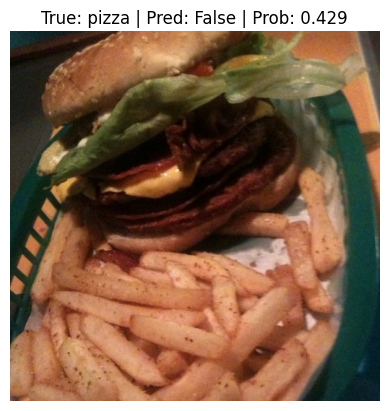

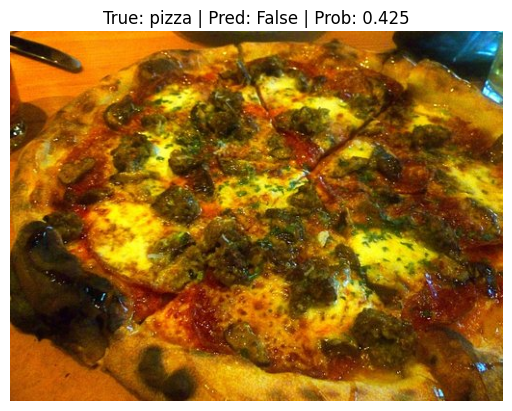

In [24]:
import torchvision
import matplotlib.pyplot as plt

# (Plot the top 5 most wrong images) 
for row in top_5_most_wrong.iterrows():
  """row 就是上述arow，長度為2"""
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # (Plot the image and various details)
  img = torchvision.io.read_image(str(image_path))  
  """
  # img是一個torch.Tensor。注意 type(image_path) 是 <class 'pathlib.PosixPath'>
  """
  plt.figure()
  plt.imshow(img.permute(1,2,0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [25]:
# TODO: Get an image of pizza/steak/sushi
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a 
"""下載的檔案名為photo-1588315029754-2dd089d39a1a，放置於根目錄 """
!cp photo-1588315029754-2dd089d39a1a pizza.jpg
"""複製檔案photo-1588315029754-2dd089d39a1a，後放置於根目錄，檔名為pizza.jpg """

--2023-05-15 13:03:36--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 199.232.46.208, 2a04:4e42:48::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.46.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4343742 (4.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a’

photo-1588315029754 100%[===================>]   4.14M  --.-KB/s    in 0.02s   

2023-05-15 13:03:36 (215 MB/s) - ‘photo-1588315029754-2dd089d39a1a’ saved [4343742/4343742]



'複製檔案photo-1588315029754-2dd089d39a1a，後放置於根目錄，檔名為pizza.jpg '

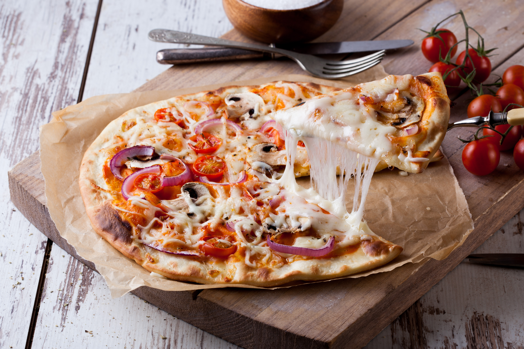

In [26]:
from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized


```
type(img_resized)
```
PIL.Image.Image


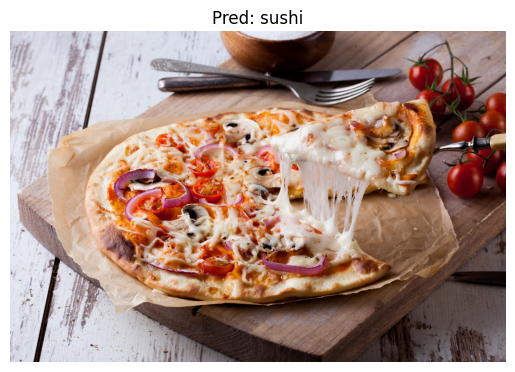

In [27]:
# (Make a function to pred and plot images)
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # (open image)
  image = Image.open(image_path)
  """type(image)是一個PIL.JpegImagePlugin.JpegImageFile"""

  # (transform image)
  transformed_image = transform(image)
  """transformed_image.shape是torch.Size([3, 224, 224])"""

  # (pred on image)
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    """pred_logit.shape=torch.Size([1, 3])"""
    pred_label = torch.argmax( torch.softmax(pred_logit,dim=1) ,dim=1)
    """pred_label是一個tensor([一個整數])"""

  
  # (plot image and pred)
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  """class_names[pred_label.item()]當然是可以，pred_label.item()就是一個整數"""
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg", 
        model=model_0, 
        transform=simple_transform,
        class_names=class_names)


In [28]:
# (Try again on a photo of steak from unsplash.com)
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

--2023-05-15 13:03:41--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 199.232.46.208, 2a04:4e42:48::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.46.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13559943 (13M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef’

photo-1546964124-0c 100%[===================>]  12.93M  --.-KB/s    in 0.04s   

2023-05-15 13:03:42 (327 MB/s) - ‘photo-1546964124-0cce460f38ef’ saved [13559943/13559943]



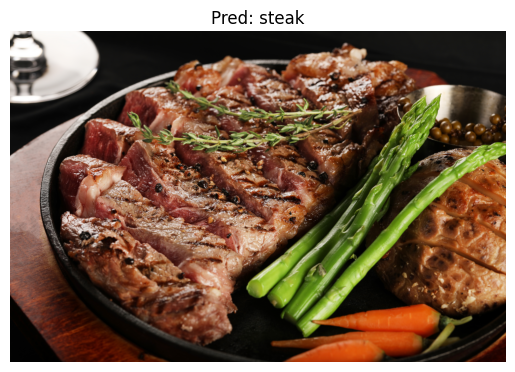

In [29]:
pred_and_plot(image_path="steak.jpg", 
        model=model_0, 
        transform=simple_transform,
        class_names=class_names)

In [30]:
# TODO: Get an image of not pizza/steak/sushi


In [31]:
# (Get an image of not pizza/steak/sushi)
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg 

--2023-05-15 13:03:49--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 199.232.46.208, 2a04:4e42:48::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.46.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6876691 (6.6M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a’

photo-1570913149827 100%[===================>]   6.56M  --.-KB/s    in 0.03s   

2023-05-15 13:03:49 (253 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a’ saved [6876691/6876691]



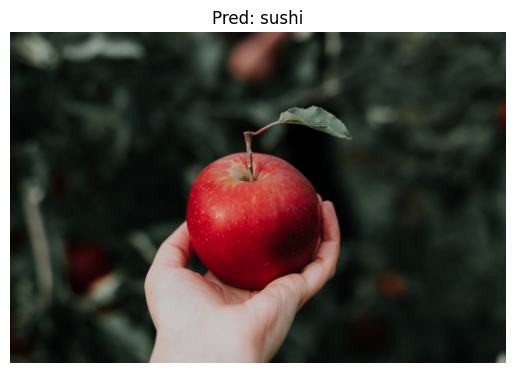

In [32]:
pred_and_plot(image_path="apple.jpg", 
        model=model_0, 
        transform=simple_transform,
        class_names=class_names)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [33]:
# TODO: Recreate a new model 
import torchvision 
from torch import nn

# model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device) 
"""舊式寫法"""

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT         
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)
"""新式寫法"""


# (Freeze the base layers)
for param in model_1.features.parameters():
  param.requires_grad = False

# (Change the classification head)
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=len(class_names),bias=True)
).to(device)

# summary(model_1, 
#     input_size=[32, 3, 224, 224],
#     col_names=["input_size", "output_size", "trainable"])

In [34]:
# TODO: Train the model for 10 epochs
# (Set the random seeds)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# (Start the timer)
from timeit import default_timer as timer
start_time = timer()

# (Create loss and optimizer) 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=0.001)

# (Setup training and save the results)
model_1_results = engine.train(model=model_1,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn, 
                  epochs=10,
                  device=device)


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0894 | train_acc: 0.4492 | test_loss: 0.9214 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8697 | train_acc: 0.7734 | test_loss: 0.8036 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7769 | train_acc: 0.7734 | test_loss: 0.7404 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7244 | train_acc: 0.7422 | test_loss: 0.6488 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6426 | train_acc: 0.7812 | test_loss: 0.6254 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6027 | train_acc: 0.7695 | test_loss: 0.5583 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5406 | train_acc: 0.9297 | test_loss: 0.5296 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5487 | train_acc: 0.8125 | test_loss: 0.5294 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5701 | train_acc: 0.7969 | test_loss: 0.4963 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.5207 | train_acc: 0.7969 | test_loss: 0.4215 | test_acc: 0.8655
[INFO] Total training time: 38.882 seconds


[INFO] Couldn't find helper_functions.py, downloading...


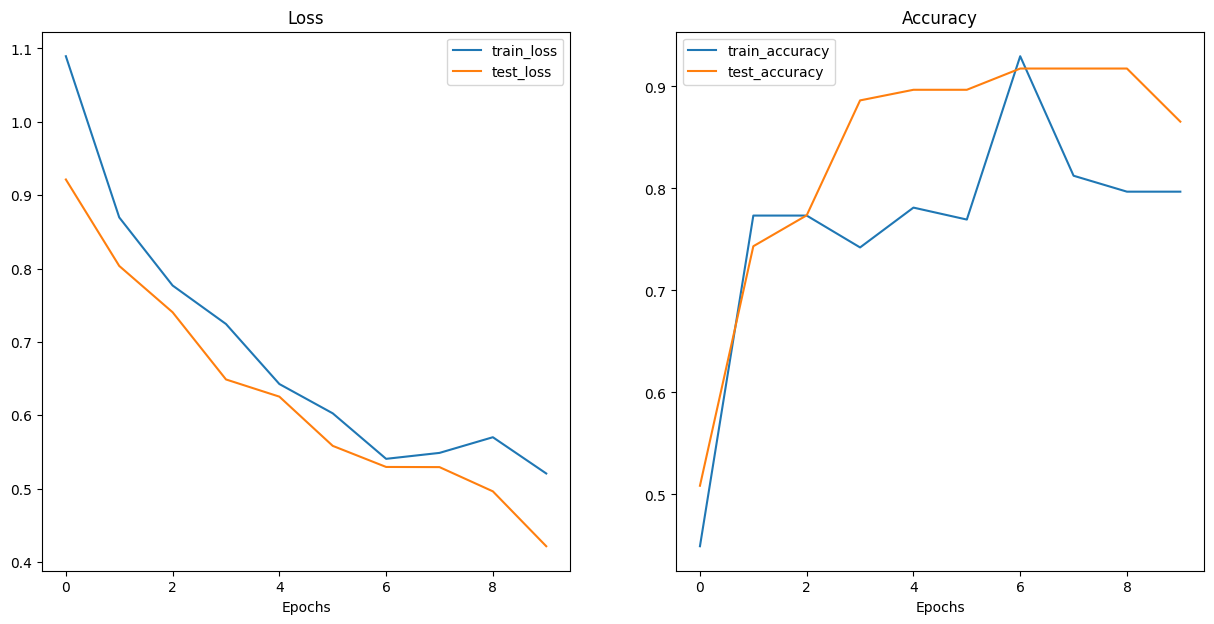

In [35]:
# (Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it)
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py","wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# (Plot the loss curves of our model)
plot_loss_curves(model_1_results)

<font color="red">If we train for longer, it looks like we get slightly lower loss and potentially higher accuracy but our model starts to look like it overfits if we train for too long.

Potentially data augmentation or a learning rate decay (lowering the learning rate over time) can help to prevent overfitting.</font>

### Get 20% data 與Get data ( 1-1 ) 基本相同 

In [36]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
"""設定 "data" 目錄路徑，物件類型為Path"""
image_path = data_path / "pizza_steak_sushi_20_percent"
'''設定 "data/pizza_steak_sushi_20_percent 資料夾路徑，物件類型為Path'''
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"
'''設定 下載檔名'''

# If the image folder doesn't exist, download it and prepare it... (檢查是否為目錄)
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  '''建立"data/pizza_steak_sushi_20_percent"目錄'''
  
  # Download pizza, steak, sushi data
  with open(data_path / image_data_zip_path, "wb") as f:
    '''開啟 pizza_steak_sushi_20_percent.zip'''
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    '''下載 pizza_steak_sushi_20_percent.zip'''
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)
    '''寫入 pizza_steak_sushi_20_percent.zip'''

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
    '''存取zip檔'''

    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)
    '''將zip檔解壓縮到"data/pizza_steak_sushi_20_percent"資料夾'''

  # Remove .zip file
  os.remove(data_path / image_data_zip_path)
  '''移除zip檔'''

# Setup Dirs
train_dir_20_percent = image_path / "train"
'''設置訓練目錄'''
test_dir_20_percent = image_path / "test"
'''設置測試目錄'''

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [37]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [38]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                        test_dir=test_dir_20_percent,
                                                        transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                        batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f729363f3a0>,
 ['pizza', 'steak', 'sushi'])

In [39]:
len(train_dataloader_20_percent), len(test_dataloader_20_percent)

(15, 5)

### Get a pretrained model

In [ ]:
# TODO

In [52]:
# (Create a new model for 20 percent of the data)
# model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)  
"""舊式寫法"""
weights_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT         
model_2 = torchvision.models.efficientnet_b0(weights=weights_2).to(device)
"""新式寫法"""

# (Freeze all the base layers)
for param in model_2.features.parameters():
  param.requires_grad = False

# (Change the classifier head)
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2,inplace=True),
  nn.Linear(in_features=1280,out_features=3,bias=True)
).to(device) 
"""在使用GPU情況下，這裡如果沒用.to(device) ，next(model_2.classifier.parameters()).is_cuda結果為False，
但運行engine.train後似乎結果沒有異常 """
print()

<font color="red">檢查model_2是否在GPU</font>
```
next(model_2.parameters()).is_cuda
```
<font color="red">檢查model_2.classifier是否在GPU</font>
```
next(model_2.classifier.parameters()).is_cuda
```


### Train a model with 20% of the data

In [ ]:
# TODO

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                  train_dataloader=train_dataloader_20_percent,
                  test_dataloader=test_dataloader_20_percent,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=5,
                  device=device)


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9753 | train_acc: 0.5625 | test_loss: 0.6485 | test_acc: 0.8886
Epoch: 2 | train_loss: 0.7084 | train_acc: 0.8187 | test_loss: 0.5306 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5867 | train_acc: 0.8292 | test_loss: 0.4531 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4557 | train_acc: 0.8875 | test_loss: 0.4102 | test_acc: 0.9034
Epoch: 5 | train_loss: 0.4524 | train_acc: 0.8896 | test_loss: 0.3795 | test_acc: 0.8852
[INFO] Total training time: 23.687 seconds


In [54]:
# (Check results with 10% of data for 5 epochs)
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6254069010416666)

In [55]:
# (Check results with 20% of data for 5 epochs) 
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.903409090909091, 0.37946638464927673)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# TODO 

In [58]:
# (Create a transform to transform the data)
from torchvision import transforms, models

effnet_b2_transform = transforms.Compose([
    transforms.Resize((288,288)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])

In [ ]:
# Use 10% data sample for effnet_b2 to compare to model_0_results
# train_dir, test_dir

In [ ]:
# from torchvision import datasets
# tdata = datasets.ImageFolder(str(data_path / "pizza_steak_sushi"))
# tdata_20 = datasets.ImageFolder(str(data_path / "pizza_steak_sushi_20_percent"))
# len(tdata),len(tdata_20)

In [59]:
# (Import the data)
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                       test_dir=test_dir,
                                                       transform=effnet_b2_transform,
                                                       batch_size=32)


In [60]:
# (Create a effnet_b2 new model - https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2)
# model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device) 
"""舊"""
weights_3 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b2(weights=weights_3).to(device)
"""新"""

# (Freeze the base layers)
for param in model_3.parameters():
  param.requires_grad = False

# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 59.5MB/s]


In [61]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# (Set the random seeds)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# (Start the timer)
from timeit import default_timer as timer
start_time = timer()

# (Setup training and save the results)
model_3_results = engine.train(model=model_3,
                  train_dataloader=train_dataloader_effnet_b2,
                  test_dataloader=test_dataloader_effnet_b2,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=5,
                  device=device)

# (End the timer and print out how long it took)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1116 | train_acc: 0.3281 | test_loss: 0.9128 | test_acc: 0.7027
Epoch: 2 | train_loss: 0.8984 | train_acc: 0.6680 | test_loss: 0.8666 | test_acc: 0.8248
Epoch: 3 | train_loss: 0.8054 | train_acc: 0.7930 | test_loss: 0.7903 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7401 | train_acc: 0.7656 | test_loss: 0.6711 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6473 | train_acc: 0.8047 | test_loss: 0.6556 | test_acc: 0.8769
[INFO] Total training time: 15.948 seconds


Which one did the best?

Experiments:

* model_0 = 10% data, effnet_b0, 5 epochs
* model_1 = 10% data, effnet_b0, 10 epochs (double training time)
* model_2 = 20% data, effnet_b0, 5 epochs (double data)
* model_3 = 10% data, effnet_b2, 5 epochs (double model parameters)

In [62]:
# (Check effnet_b0 results with 10% of data for 5 epochs)
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.8967803030303031, 0.6254069010416666)

In [63]:
# (Check effnet_b0 results with 10% of data for 10 epochs (double training time))
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.9176136363636364, 0.42152056097984314)

In [64]:
# (Check effnet_b0 results with 20% of data for 5 epochs (double data))
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.903409090909091, 0.37946638464927673)

In [65]:
# (Check effnet_b2 results with 10% of data for 5 epochs (double model parameters))
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9280303030303031, 0.655631442864736)